In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
import math

%matplotlib inline

In [2]:
def display_image_set(imgs, filename, cols_num=6):
    imgs_num = len(imgs)
    width_img = int(math.ceil(float(300) / float(cols_num)))
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    height_init, width_init, channel = imgs[0].shape
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, channel)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)
    
    for idx, img in enumerate(imgs):
        row = idx // cols_num
        col = idx - row * cols_num

        img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.rcParams["figure.figsize"] = (25, 25)
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()
    
def load_images(directory):
    imgs = []
    files = glob.glob('./{}/*.jpg'.format(directory))

    for fname in files:
        imgs.append(mpimg.imread(fname))
        
    return imgs

def write_images(imgs, directory, namebase):
    for idx, img in enumerate(imgs):
        path = './' + directory + '/' + namebase + str(idx) + '.jpg'
        cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
def save_hist(image, binary, hist, idx, show=False):
    binary_width = binary.shape[1]
    binary_height = binary.shape[0]
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 11))
    ax1.yaxis.tick_left()
    ax1.tick_params(axis='y', colors='black', labelsize=15)
    ax1.tick_params(axis='x', colors='black', labelsize=15)
    ax1.grid(b=True, which='major', color='#D3D3D3', linestyle='-')
    ax1.plot(hist, lw=3, color='red')
    ax1.imshow(binary, aspect='auto', extent=(0, binary_width, 0, binary_height), zorder=-1, cmap='gray')
    ax2.imshow(image, cmap='gray')
    f.savefig('./lanes/hist_{}.jpg'.format(idx))
    
    if show:
        plt.show()
        
    plt.close(f)
    
def save_curves(img, curves, shape, idx, show=False):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    f, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(img)
    ax.axis('off') 
    ax.plot(curves[0], ploty, color='green', lw=5)
    ax.plot(curves[1], ploty, color='green', lw=5)
    plt.xlim(0, shape[1])
    plt.ylim(shape[0], 0)
    f.savefig('./lanes/curves_{}.jpg'.format(idx))
    
    if show:
        plt.show()
        
    plt.close(f)

In [27]:
def find_corners(grids):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)
    objp = objp * 57

    objpoints = []
    imgpoints = []
    good_grids = []
    bad_grids = []

    for img in grids:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (6,9), None)

        if ret == True:
            corners_refined = cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)
            img = cv2.drawChessboardCorners(img, (6,9), corners_refined, ret)

            objpoints.append(objp)
            imgpoints.append(corners_refined)
            good_grids.append(img)
        else:
            bad_grids.append(img)
            
    display_image_set(good_grids, 'good_grids', cols_num=6)
    display_image_set(bad_grids, 'bad_grids', cols_num=6)
            
    return objpoints, imgpoints

def calibrate(grids, objpoints, imgpoints):
    grid = grids[0]
    shape = grid.shape[:2][::-1]
    w, h = shape
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    dst = cv2.undistort(grid, mtx, dist, None, newcameramtx)

    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    mean_error = 0
    
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        mean_error += error

    print("total error:", mean_error/len(objpoints))
    return mtx, dist, newcameramtx

def calibrate_camera(directory):
    grids = load_images(directory)
    objpoints, imgpoints = find_corners(grids)
    mtx, dist, newcameramtx = calibrate(grids, objpoints, imgpoints)
    
    return mtx, dist, newcameramtx

def undistort(imgs, mtx, dist, newcameramtx):
    grids_undist = []

    for image in imgs:
        grid_undist = cv2.undistort(image, mtx, dist, None, newcameramtx)
        grids_undist.append(grid_undist)
        
    return grids_undist

def warp_matrix(image):
    h, w, _ = image.shape
    center_x = 0.5 * w
    margin_bottom = 0.13
    margin_top = 0.37

#     src = np.float32([
#         [center_x - 285, h - h * margin_bottom], #left bottom
#         [center_x - 43, h - h * margin_top], #left top
#         [center_x + 68, h - h * margin_top], #right top
#         [center_x + 325, h - h * margin_bottom] #right bottom
#     ])
    
    src = np.float32([
        [0, 720], #left bottom
        [center_x - 63, h - h * margin_top], #left top
        [center_x + 88, h - h * margin_top], #right top
        [1279, 720] #right bottom
    ])

    dst = np.float32([
        [center_x - center_x / 2, h],
        [center_x - center_x / 2, 0],
        [center_x + center_x / 2, 0],
        [center_x + center_x / 2, h]
    ])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv, src

def warp(images, M, src_warp):
    images_demo = []
    images_warped = []
    
    for img in images:
        img_size = img.shape[:2][::-1]
        image_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        images_warped.append(image_warped)

        image_demo = np.copy(img)
        cv2.polylines(image_demo, np.int_([src_warp]), True, (255, 0, 0), thickness=3)
        images_demo.append(image_demo)
    
    return images_warped, images_demo

def build_hist(binary):
    binary_height = binary.shape[0]
    binary_half_height = int(binary_height / 2)
    
    return np.sum(binary[binary_half_height:,:], axis=0)

def polyfit(y, x, ploty):
    fit = np.polyfit(y, x, 2)
    return fit[0]*ploty**2 + fit[1]*ploty + fit[2]

def draw_lane(image, curves, matrix_inv):
    ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
    color_warp = np.zeros(image.shape, dtype='uint8')
    pts_left = np.array([np.transpose(np.vstack([curves[0], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([curves[1], ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    lane = cv2.warpPerspective(color_warp, matrix_inv, (image.shape[1], image.shape[0])) 
    
    return cv2.addWeighted(image, 1, lane, 0.3, 0)

def curve_rad(curve, ploty):
    y_eval = np.max(ploty)
    return ((1 + (2*curve[0]*y_eval + curve[1])**2)**1.5) / np.absolute(2*curve[0])

def curvature(fit, y, x, ploty):
    lane_width = 3.7
    visible_length = 30
    
    y_eval = np.max(ploty)
    curverad = curve_rad(fit, ploty)
    ym_per_pix = visible_length / y_eval # meters per pixel in y dimension
    xm_per_pix = lane_width / y_eval # meters per pixel in x dimension

    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    return curverad

def sliding_windows(hist, binary, background):
    out_img = np.copy(background)
    fits = []
    margin = 50
    minpix = 50
    nwindows = 9
    
    height = hist.shape[0]
    window_height = np.int(height / nwindows)
    binary_shape = binary.shape
    binary_height = binary_shape[0]
    midpoint = np.int(hist.shape[0] / 2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    
    for x_base in [leftx_base, rightx_base]:
        nonzero = binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        x_current = x_base
        lane_inds = []

        for window in range(nwindows):
            win_y_low = binary_height - (window + 1) * window_height
            win_y_high = binary_height - window * window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin

            cv2.rectangle(out_img, (win_x_low, win_y_low), (win_x_high, win_y_high), (255,0,0), 1) 

            good_inds = ((nonzeroy >= win_y_low) 
                              & (nonzeroy < win_y_high) 
                              & (nonzerox >= win_x_low) 
                              & (nonzerox < win_x_high)).nonzero()[0]
            lane_inds.append(good_inds)
            
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        
        lane_inds = np.concatenate(lane_inds)
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        ploty = np.linspace(0, binary_height - 1, binary_height)
        out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
        fit = polyfit(y, x, ploty)
        fits.append(fit)

    curved = curvature(fit, y, x, ploty)
    
    return curved, fits, out_img

In [20]:
def extract_yellow(img, thresh_min=0, thresh_max=255):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 50, 150), (40, 255, 255))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return gray

def extract_highlights(img, p=99.9):
    p = int(np.percentile(img, p) - 30)
    return cv2.inRange(img, p, 255)

def binary_noise_reduction(img, thresh):
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbors = cv2.filter2D(img, ddepth=-1, kernel=k)
    img[nb_neighbors < thresh] = 0
    
    return img

def binarize(img):
    hls_binary = hls_select(img, s_thresh=(100, 255), sx_thresh=(10, 200))
    gray = np.max(hls_binary, 2)
    
    ylw = extract_yellow(img)
    highlights = extract_highlights(img[:, :, 0])
    
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    
    mag_binary = mag_thresh(img, sobel_kernel=7, mag_thresh=(30, 255))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.2, 1))
    
#     hls_binary = hls_select(img, s_thresh=(170, 255), sx_thresh=(20, 100))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1)) 
             | ((mag_binary == 1) & (dir_binary == 1))
             | (ylw == 255) 
             | (highlights == 255)] = 1
    combined = binary_noise_reduction(combined, 4)
    
    return combined

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    if img.shape[-1] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
        
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag) / 255 
    gradmag = (gradmag / scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def hls_select(img, s_thresh=(0, 255), sx_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    
    l_channel = hls[:,:,1]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    return np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))

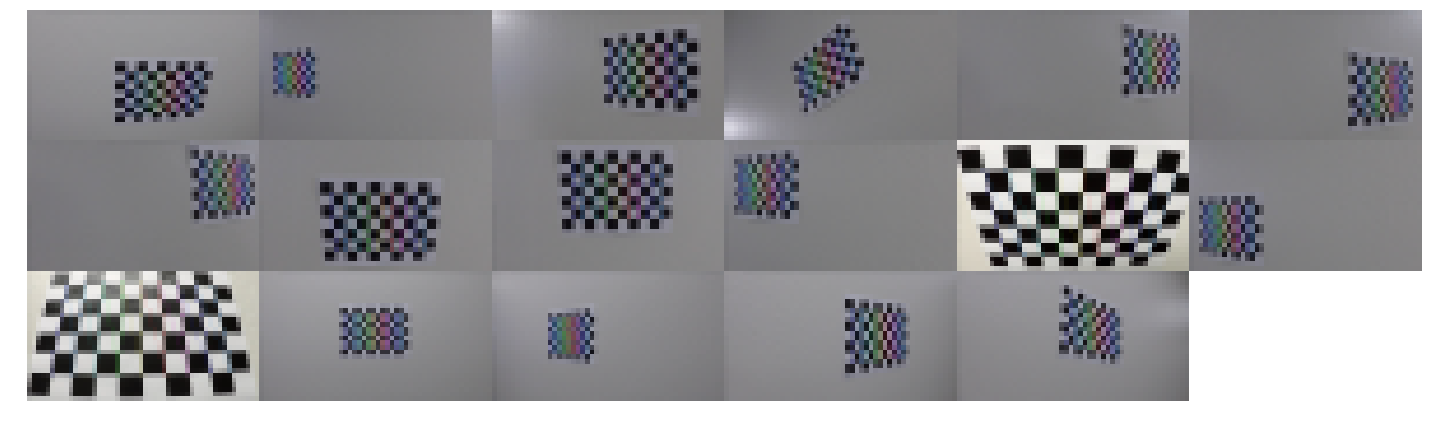

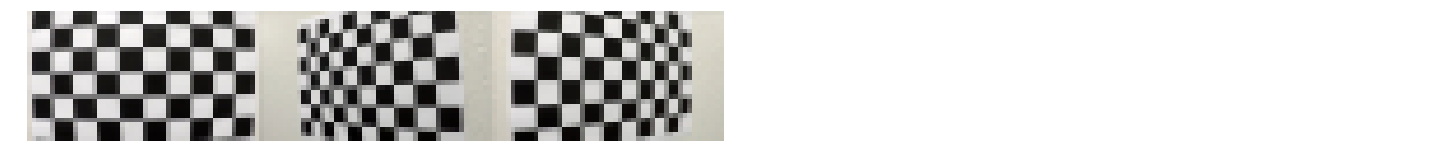

total error: 0.10817529030553186


In [11]:
mtx, dist, newcameramtx = calibrate_camera('camera_cal')

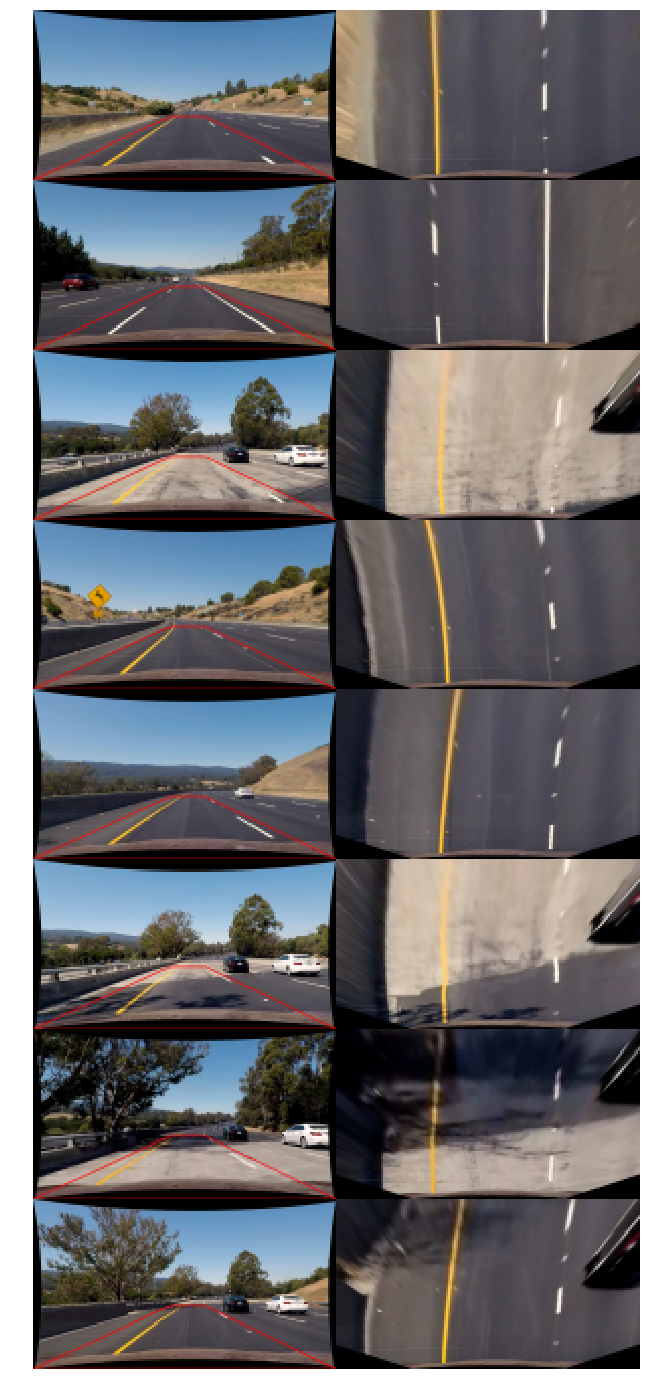

In [28]:
images = load_images('test_images')
images_undist = undistort(images, mtx, dist, newcameramtx)
image_sample = images_undist[0]

M, Minv, src_warp = warp_matrix(image_sample)
images_warped, images_demo = warp(images_undist, M, src_warp)

warped_demo = [j for i in zip(images_demo, images_warped) for j in i]
display_image_set(warped_demo, 'warped', cols_num=2)
write_images(images_warped, 'warped', 'warped')

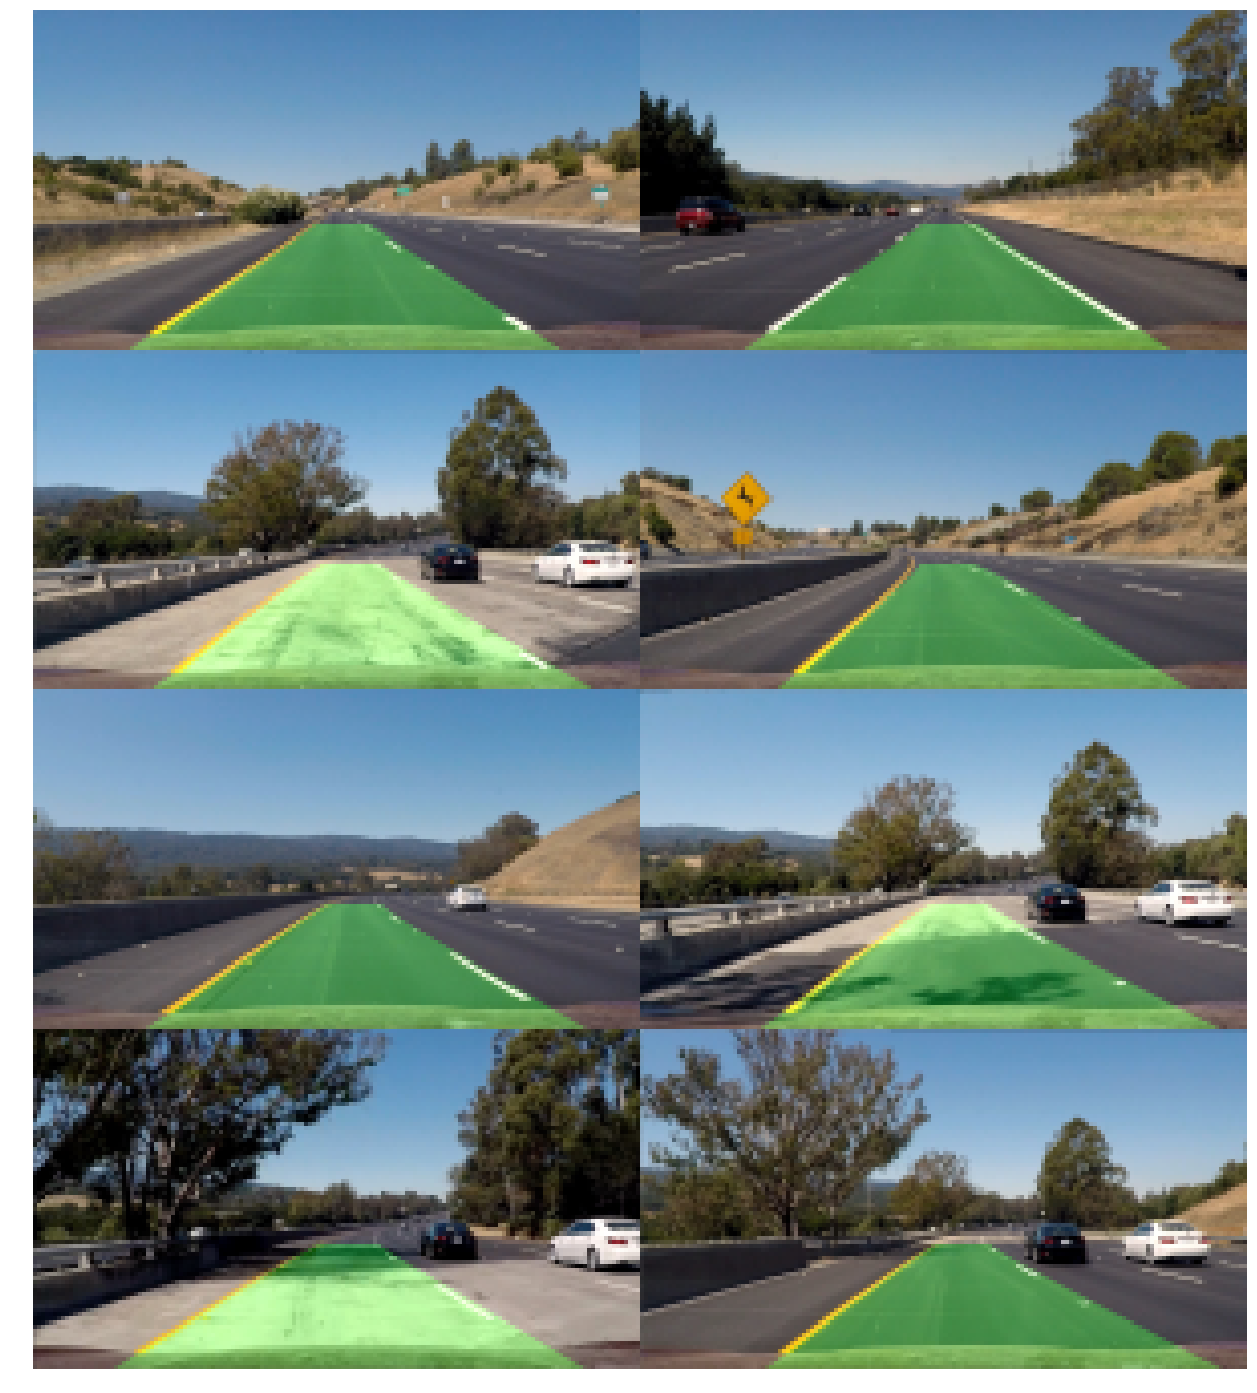

In [ ]:
lanes = []

for idx, warped in enumerate(images_warped):
    binary = binarize(warped)
    hist = build_hist(binary)
    save_hist(warped, binary, hist, idx)
    
    curved, curves, image_with_win = sliding_windows(hist, binary, warped)
    save_curves(image_with_win, curves, binary.shape, idx)
    
    image = images[idx]
    lane = draw_lane(image, curves, Minv)
    lanes.append(lane)
    
display_image_set(lanes, 'lanes', cols_num=2)

In [ ]:
def process_frame(image, mtx, dist, newcameramtx):
    image_undist = undistort([image], mtx, dist, newcameramtx)[0]
    M, Minv, src_warp = warp_matrix(image)
    images_warped, _ = warp([image_undist], M, src_warp)
    warped = images_warped[0]
    binary = binarize(warped)
    hist = build_hist(binary)
    _, curves, _ = sliding_windows(hist, binary, warped)
    lane = draw_lane(image, curves, Minv)
    
    return lane

image = load_images('test_images')[3]
lane = process_frame(image, mtx, dist, newcameramtx)
plt.imshow(lane)

In [12]:
# class Line():
#     def __init__(self):
#         # was the line detected in the last iteration?
#         self.detected = False  
#         # x values of the last n fits of the line
#         self.recent_xfitted = [] 
#         #average x values of the fitted line over the last n iterations
#         self.bestx = None     
#         #polynomial coefficients averaged over the last n iterations
#         self.best_fit = None  
#         #polynomial coefficients for the most recent fit
#         self.current_fit = [np.array([False])]  
#         #radius of curvature of the line in some units
#         self.radius_of_curvature = None 
#         #distance in meters of vehicle center from the line
#         self.line_base_pos = None 
#         #difference in fit coefficients between last and new fits
#         self.diffs = np.array([0,0,0], dtype='float') 
#         #x values for detected line pixels
#         self.allx = None  
#         #y values for detected line pixels
#         self.ally = None



In [ ]:
# def window_mask(width, height, img_ref, center,level):
#     output = np.zeros_like(img_ref)
#     output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
#     return output

# def find_window_centroids(image, window_width, window_height, margin):
#     window_centroids = [] # Store the (left,right) window centroid positions per level
#     window = np.ones(window_width) # Create our window template that we will use for convolutions
    
#     # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
#     # and then np.convolve the vertical image slice with the window template 
#     # Sum quarter bottom of image to get slice, could use a different ratio
#     half_width = int(image.shape[1] / 2)
#     quarter_height = int(3 * image.shape[0] / 4)
#     left_part = image[quarter_height:, :half_width]
#     right_part = image[quarter_height:, half_width:]
    
#     l_sum = np.sum(left_part, axis=0)
#     l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2
    
#     r_sum = np.sum(right_part, axis=0)
#     r_center = np.argmax(np.convolve(window, r_sum)) - window_width / 2 + half_width
    
#     # Add what we found for the first layer
#     window_centroids.append((l_center, r_center))
#     print(window_centroids)
    
#     # Go through each layer looking for max pixel locations
#     for level in range(1,(int)(warped.shape[0]/window_height)):
#         # convolve the window into the vertical slice of the image
#         image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
#         conv_signal = np.convolve(window, image_layer)
#         # Find the best left centroid by using past left center as a reference
#         # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
#         offset = window_width/2
#         l_min_index = int(max(l_center+offset-margin,0))
#         l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
#         l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
#         # Find the best right centroid by using past right center as a reference
#         r_min_index = int(max(r_center+offset-margin,0))
#         r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
#         r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
#         # Add what we found for that layer
#         window_centroids.append((l_center,r_center))

#     return window_centroids

# warped = np.copy(img)
# window_width = 50 
# window_height = 80 # Break image into 9 vertical layers since image height is 720
# margin = 100 # How much to slide left and right for searching

# window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# # If we found any window centers
# if len(window_centroids) > 0:
#     # Points used to draw all the left and right windows
#     l_points = np.zeros_like(warped)
#     r_points = np.zeros_like(warped)

#     # Go through each level and draw the windows    
#     for level in range(0,len(window_centroids)):
#         # Window_mask is a function to draw window areas
#         l_mask = window_mask(window_width, window_height, warped, window_centroids[level][0], level)
#         r_mask = window_mask(window_width, window_height, warped, window_centroids[level][1], level)
#         # Add graphic points from window mask here to total pixels found 
#         l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#         r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

#     # Draw the results
#     template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#     zero_channel = np.zeros_like(template) # create a zero color channel
#     template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#     warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
#     output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
# # If no window centers found, just display orginal road image
# else:
#     output = np.array(cv2.merge((warped, warped, warped)),np.uint8)

# # Display the final results
# plt.imshow(output)
# plt.title('window fitting results')
# plt.show()

In [ ]:
# img = unwarpeds[0]
# half_height = int(img.shape[0] / 2)
# max_y = 0

# plt.figure(figsize=(10,10))
# fig, ax = plt.subplots()
# ax.yaxis.tick_left()
# ax.tick_params(axis='y', colors='black', labelsize=15)
# ax.tick_params(axis='x', colors='black', labelsize=15)
# ax.grid(b=True, which='major', color='#D3D3D3', linestyle='-')

# for i, color in enumerate(['red', 'green', 'blue']):
#     hist = np.sum(img[half_height:,:,i], axis=0)
#     ax.plot(hist, '-o', ms=3, lw=1, alpha=1.0, color=color)
#     max_y = max(max(hist), max_y)
    
# ax.imshow(img, aspect='auto', extent=(0, img.shape[1], 0, max_y), zorder=-1)
# plt.show()